In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 1.4 MB/s eta 0:00:0000:0100:05m


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
# improt scipy
from scipy import sparse

Read the data and store idx of rows we want to predict hplus for like you did

In [ ]:
# Load the dataset
df_XGB = pd.read_csv("df_guims.csv")

# Shuffle the dataset and reset the index
df_XGB = df_XGB.sample(frac=1.0, random_state=123).reset_index(drop=True)

# store the index of the rows with missing values in the 'hplus' column
missing_idx = df_XGB.index[df_XGB["hplus"].isna()].to_list()

In [20]:
df_XGB.head()

,hplus,wsalred_CMA,wsalred_LMA,wsalred_lowess,sexe,age,ancentr,zus,empnbh,etranger,...,naf10_Construction,"naf10_Commerce de gros et de détail, transports, hébergement et restauration",naf10_Information et communication,naf10_Activités financières et d'assurance,naf10_Activités immobilières,"naf10_Activités spécialisées, scientifiques et techniques et activités de services administratifs et de soutien",naf10_Autres activités de services,season_Summer,season_Autumn,season_Winter
0,NaN,1450.915283,1685.588379,1463.856934,0,29,36.0,0.0,39.0,1.0,...,0,0,0,0,0,1,0,1,0,0
1,NaN,1571.952515,1585.973022,1478.044800,1,46,74.0,1.0,28.0,3.0,...,0,0,0,0,0,1,0,1,0,0
2,NaN,1218.000000,1218.000000,1218.000000,1,39,12.0,0.0,35.0,3.0,...,0,0,0,0,0,0,0,0,1,0
3,NaN,3000.000000,3000.000000,3000.000000,1,55,180.0,0.0,45.0,3.0,...,0,0,0,1,0,0,0,0,0,1
4,40.0,1318.879395,1368.816528,1403.238525,1,58,60.0,0.0,36.5,1.0,...,0,1,0,0,0,0,0,1,0,0


### Trying with Dense Matrix

I convert the data to matrices because thats the input xgb expects (written in C++) 

You could either do a dense numpy array (all the elements are stored, not just non-0, its more simple and no compression)

In [5]:
# Rows where 'hplus' is here
df_train   = df_XGB.loc[~df_XGB["hplus"].isna()]
# Rows where 'hplus' is missing
df_missing = df_XGB.loc[df_XGB["hplus"].isna()]

# Convert the DataFrame to numpy arrays (dense)
X_train   = df_train.drop(columns=["hplus"]).to_numpy()
# Same for the missing values
X_missing = df_missing.drop(columns=["hplus"]).to_numpy()

# Target vector as a 1-D numpy array
y_train   = df_train["hplus"].to_numpy()

# Now you wrap the X/y data into DMatrix objects
# DMatrix is an internal data structure that XGBoost uses to optimize memory usage and training speed
# It can handle both dense and sparse data
# It compresses the data and stores it in a more efficient format basically
dtrain   = xgb.DMatrix(X_train, label=y_train)
dmissing = xgb.DMatrix(X_missing)


nrounds is like how many consecutive trees we let the booster have (because in XGB basically you make a random forest tree, and then you train the next tree on the residuals of the first tree etc. for nrounds so one of the most impt params I think)

Also the cross validation technique is good. That way you know better the generalisation capabilities of your model because we aggregte the fold wise test errors to get the total RMSE

reg:squarederror RMSE is good loss for basic regression (if target was log normal use the squared log error)

eta = 0.1 apparently usually learning rate between 0.01 and 0.3 so should be good. This one shrinks the contribution of how much each trees contributes to prediction of output

max_depth = 6 apparently this is common max depth, its just the longest path from root to leaf of ur decition tree

nfold=10 nb of cross validation, I think 10 is good doesnt matter too much

early_stopping = this is like a regularisation technique, you stop if the val loss doesnt decrease after a set of 10 iterations (dont allow model to overfit)



In [ ]:
# I just put the same params as you
params = {
    "objective":"reg:squarederror",
    "eta":0.1,
    "max_depth":6,
    "seed":123}

# Train the model with cross-validation
cv_results = xgb.cv(params=params,dtrain=dtrain,num_boost_round=1000,nfold=10,
                    early_stopping_rounds=10,verbose_eval=True)

# this is how many rounds that achieved the optimal validation RMSE
best_nrounds = cv_results.shape[0]
print(f"Best number of rounds: {best_nrounds}")

# Final row of cv_results (train/test RMSE, std)
model_worth_dense = cv_results.iloc[-1]
print(f"Train RMSE: {model_worth_dense['train-rmse-mean']:.4f} +/- {model_worth_dense['train-rmse-std']:.4f}")
print(f"Test RMSE: {model_worth_dense['test-rmse-mean']:.4f} +/- {model_worth_dense['test-rmse-std']:.4f}")

# Trains a booster on the full training dataset (no need validation anymore because now we know optimal number of rounds)
# using the optimal number of rounds
# This model we use to predict the missing hplus values
final_model_dense = xgb.train(params=params,dtrain=dtrain,num_boost_round=best_nrounds)


[0]	train-rmse:7.20390+0.02509	test-rmse:7.21184+0.22466
[1]	train-rmse:7.08074+0.02474	test-rmse:7.09977+0.22325
[2]	train-rmse:6.97728+0.02469	test-rmse:7.00732+0.22187
[3]	train-rmse:6.89028+0.02423	test-rmse:6.93005+0.22107
[4]	train-rmse:6.81694+0.02415	test-rmse:6.86622+0.21934
[5]	train-rmse:6.75466+0.02406	test-rmse:6.81415+0.21790
[6]	train-rmse:6.70081+0.02391	test-rmse:6.77165+0.21553
[7]	train-rmse:6.65397+0.02361	test-rmse:6.73602+0.21431
[8]	train-rmse:6.61307+0.02337	test-rmse:6.70552+0.21290
[9]	train-rmse:6.57681+0.02337	test-rmse:6.67838+0.21234
[10]	train-rmse:6.54442+0.02368	test-rmse:6.65537+0.21132
[11]	train-rmse:6.51466+0.02237	test-rmse:6.63565+0.21230
[12]	train-rmse:6.48748+0.02293	test-rmse:6.61833+0.21061
[13]	train-rmse:6.46278+0.02317	test-rmse:6.60280+0.20986
[14]	train-rmse:6.44032+0.02321	test-rmse:6.58975+0.20957
[15]	train-rmse:6.42057+0.02418	test-rmse:6.57934+0.20891
[16]	train-rmse:6.40119+0.02366	test-rmse:6.56852+0.20968
[17]	train-rmse:6.38259+

### Method 2 Trying the sparse CSR matrix

Sparse CSR matrix
Trying to use sparse matrix as well (stores only the non-0 values smaller RAM footprint and skips more easily absent features appaz)

In [8]:
df_train_sp   = df_XGB.loc[~df_XGB["hplus"].isna()]
df_missing_sp = df_XGB.loc[df_XGB["hplus"].isna()]

X_train_sp   = sparse.csr_matrix(df_train_sp.drop(columns=["hplus"]).values)
y_train_sp   = df_train_sp["hplus"].values
X_missing_sp = sparse.csr_matrix(df_missing_sp.drop(columns=["hplus"]).values)

dtrain_sp   = xgb.DMatrix(X_train_sp, label=y_train_sp)
dmissing_sp = xgb.DMatrix(X_missing_sp)


In [9]:
cv_results_sp = xgb.cv(params=params,dtrain=dtrain_sp,num_boost_round=1000,nfold=10,
                       early_stopping_rounds=10,verbose_eval=True)
best_nrounds_sp = cv_results_sp.shape[0]
model_worth_sparse = cv_results_sp.iloc[-1]

final_model_sparse = xgb.train(params=params,dtrain=dtrain_sp,num_boost_round=best_nrounds_sp)


[0]	train-rmse:7.20402+0.02511	test-rmse:7.21172+0.22475
[1]	train-rmse:7.08086+0.02474	test-rmse:7.09974+0.22292
[2]	train-rmse:6.97736+0.02464	test-rmse:7.00730+0.22153
[3]	train-rmse:6.89046+0.02420	test-rmse:6.93035+0.22068
[4]	train-rmse:6.81710+0.02424	test-rmse:6.86684+0.21896
[5]	train-rmse:6.75489+0.02412	test-rmse:6.81458+0.21690
[6]	train-rmse:6.70130+0.02369	test-rmse:6.77194+0.21505
[7]	train-rmse:6.65441+0.02337	test-rmse:6.73670+0.21445
[8]	train-rmse:6.61346+0.02319	test-rmse:6.70680+0.21248
[9]	train-rmse:6.57737+0.02286	test-rmse:6.68022+0.21228
[10]	train-rmse:6.54490+0.02258	test-rmse:6.65763+0.21096
[11]	train-rmse:6.51518+0.02220	test-rmse:6.63804+0.21039
[12]	train-rmse:6.48869+0.02265	test-rmse:6.61964+0.21095
[13]	train-rmse:6.46308+0.02295	test-rmse:6.60508+0.21017
[14]	train-rmse:6.44025+0.02234	test-rmse:6.59171+0.20854
[15]	train-rmse:6.41958+0.02291	test-rmse:6.58046+0.20789
[16]	train-rmse:6.40034+0.02297	test-rmse:6.57095+0.20911
[17]	train-rmse:6.38227+

Looks like gave better results (but overfits a bit train < test RMSE means the model is better at predicting data its seen during training, so its learned patterns in the training set that arent 'generalizable' ones)

Should do a hyperparameter search cuz theyre quite important its super dependant on ur dataset what u get as hyperparams

eta is the learning rate as i was saying above, max depth, subsample and colsample bytree recommended by GPT

subsample is the fraction of training rows that you sample (without replacement) to build each tree (as I understand it also to regularize (avoid overfitting to training data)). Cuz otherwise specific points or x data could have too much influence on outputs

colsample_bytree is the fraction of the X features you sample at random per tree (before choosing split), so each tree is forced to consider only a subset of predictors (better for model diversity, generalisation as I see it). ou baso force the model to explore alternative splits to make more diverse set of decision rules



In [10]:
import random, json, math, time
search_space = {
    "eta":       lambda: 10**random.uniform(math.log10(0.01), math.log10(0.3)), # use log otherwise itll get stuck in low values
    "max_depth": lambda: random.randint(3,10), # as per GPT suggested
    "subsample": lambda: random.uniform(0.6,1.0), # as per GPT suggested
    "colsample_bytree": lambda: random.uniform(0.6,1.0) # as per GPT suggested
}
trials = 30
best_rmse = float("inf")
best_params = None
best_nrounds_rs = None
for _ in range(trials):
    p = {k:f() for k,f in search_space.items()}
    p.update(objective="reg:squarederror",seed=123)
    cv = xgb.cv(params=p,dtrain=dtrain,num_boost_round=2000,nfold=10,
                early_stopping_rounds=20,verbose_eval=False)
    rmse = cv["test-rmse-mean"].min()
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = p
        best_nrounds_rs = cv["test-rmse-mean"].idxmin()+1
print(best_params,best_rmse,best_nrounds_rs)


{'eta': 0.013281945396921308, 'max_depth': 10, 'subsample': 0.9305564736564534, 'colsample_bytree': 0.6142406771345253, 'objective': 'reg:squarederror', 'seed': 123} 6.184373861053369 2000


In [13]:
print("Best params:")
print(best_params)

print("Best RMSE:")
print(best_rmse)

print("Best number of rounds:")
print(best_nrounds_rs)

Best params:
{'eta': 0.013281945396921308, 'max_depth': 10, 'subsample': 0.9305564736564534, 'colsample_bytree': 0.6142406771345253, 'objective': 'reg:squarederror', 'seed': 123}
Best RMSE:
6.184373861053369
Best number of rounds:
2000


In [12]:
final_model_best = xgb.train(params=best_params,dtrain=dtrain,
                             num_boost_round=best_nrounds_rs, verbose_eval=True)

In [14]:
# save the model
final_model_best.save_model("xgb_model.json")

Ca shap values cest utilise la masse en ML, basically you just look at which input x variables contribute the most to what the output will be.

Use them to A debug (if one variable hase a hugeeee shap value theres probably a problem) B good to know which of the inputs is important to predict ur Y

/tmp/ipykernel_19348/2602006959.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,X_train,plot_type="bar")


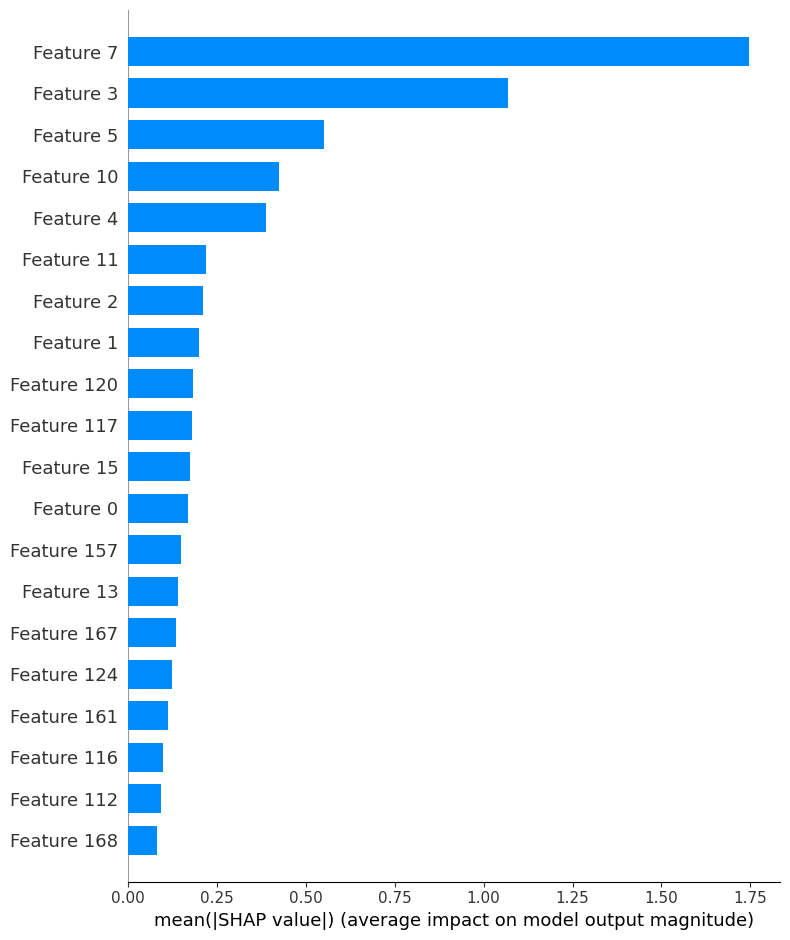

In [19]:
import shap
explainer = shap.TreeExplainer(final_model_best)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values,X_train,plot_type="bar")

I think this is kinda like SHAP but made by XGBoost

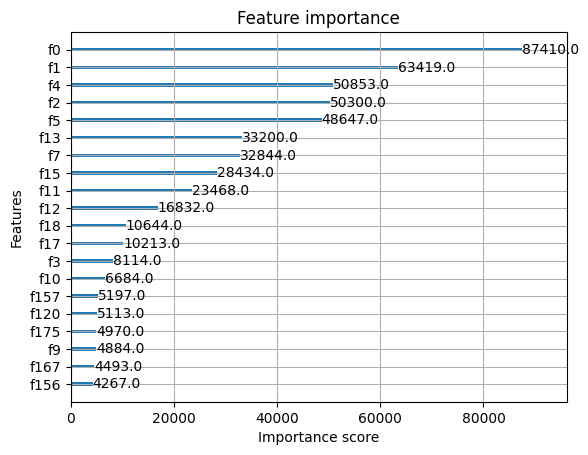

In [21]:
import matplotlib.pyplot as plt
xgb.plot_importance(final_model_best,max_num_features=20)
plt.show()

Idk why they dont give the same results tbf, would need to ook at how they are calculated. Also maybe because in the end the data isnt setup correctly?

Usually we also compare to regular ridge regression (you can look up what it is. la dc ca te montre que XGBoost actually useful cuz we get like much better perf)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

ridge_pipe = Pipeline([
    ("impute",  SimpleImputer(strategy="median")),
    ("scale",   StandardScaler(with_mean=False)),
    ("model",   Ridge(alpha=1.0, random_state=123))
])

kf = KFold(n_splits=10, shuffle=True, random_state=123)
neg_mse = cross_val_score(ridge_pipe, X_train, y_train, cv=kf,
                          scoring="neg_mean_squared_error")
ridge_rmse = np.mean(np.sqrt(-neg_mse))
print(ridge_rmse)


6.742991398972778


In [22]:
predicted_hplus_sparse = final_model_best.predict(dmissing_sp)
df_XGB.loc[missing_idx,"hplus"] = predicted_hplus_sparse
# df_XGB.to_csv("Data/Clean/df_guims_completed_sparse.csv",index=False)


In [23]:
df_XGB

,hplus,wsalred_CMA,wsalred_LMA,wsalred_lowess,sexe,age,ancentr,zus,empnbh,etranger,...,naf10_Construction,"naf10_Commerce de gros et de détail, transports, hébergement et restauration",naf10_Information et communication,naf10_Activités financières et d'assurance,naf10_Activités immobilières,"naf10_Activités spécialisées, scientifiques et techniques et activités de services administratifs et de soutien",naf10_Autres activités de services,season_Summer,season_Autumn,season_Winter
0,30.772005,1450.915283,1685.588379,1463.856934,0,29,36.0,0.0,39.0,1.0,...,0,0,0,0,0,1,0,1,0,0
1,25.188660,1571.952515,1585.973022,1478.044800,1,46,74.0,1.0,28.0,3.0,...,0,0,0,0,0,1,0,1,0,0
2,26.123150,1218.000000,1218.000000,1218.000000,1,39,12.0,0.0,35.0,3.0,...,0,0,0,0,0,0,0,0,1,0
3,33.604858,3000.000000,3000.000000,3000.000000,1,55,180.0,0.0,45.0,3.0,...,0,0,0,1,0,0,0,0,0,1
4,40.000000,1318.879395,1368.816528,1403.238525,1,58,60.0,0.0,36.5,1.0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311965,18.132454,1789.000000,1789.000000,1789.000000,1,42,276.0,0.0,39.0,1.0,...,0,1,0,0,0,0,0,1,0,0
311966,22.140684,2231.789795,2217.052734,2189.800293,1,57,396.0,0.0,40.0,1.0,...,0,0,0,0,0,0,0,0,0,1
311967,35.835403,2216.672852,1993.383667,1893.187866,1,45,156.0,0.0,55.0,1.0,...,0,1,0,0,0,0,0,1,0,0
311968,32.108860,1525.133179,1498.694946,1541.705811,0,49,348.0,0.0,45.0,1.0,...,0,0,0,0,0,1,0,1,0,0
